In [1]:
import re
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
# Path to the folder containing the Excel files
#folder_path = r'H:\api_data\TCS_1hr'
folder_path = r'C:\Users\ADMIN\Desktop\nifty_range\5min'

# Function to extract the batch number from file names
def extract_batch_number(filename):
    match = re.search(r'batch_(\d+)', filename)
    return int(match.group(1)) if match else float('inf')

# Get a list of all Excel files in the folder, sorted by batch number
excel_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx') or f.endswith('.xls')], key=extract_batch_number)

# Initialize an empty list to store dataframes
dfs = []

# Loop through each Excel file, read it, and append the dataframe to the list
for file in excel_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    # Ensure DateTime is parsed consistently across files
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    dfs.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dfs)

# Ensure 'DateTime' column is in datetime format and sort by it in ascending order (oldest to newest)
combined_df = combined_df.sort_values(by='DateTime', ascending=True)

# Reset the index after sorting
combined_df.reset_index(drop=True, inplace=True)

In [2]:
combined_df.tail()

,DateTime,Open,High,Low,Close,Volume
183926,2025-06-27 15:05:00,25643.35,25644.50,25624.25,25630.60,0
183927,2025-06-27 15:10:00,25631.30,25634.85,25626.45,25633.00,0
183928,2025-06-27 15:15:00,25632.60,25648.40,25631.75,25647.60,0
183929,2025-06-27 15:20:00,25646.10,25649.95,25638.80,25642.30,0
183930,2025-06-27 15:25:00,25641.25,25648.10,25629.60,25632.45,0


In [4]:
import pandas as pd
import numpy as np

# -----------------------------
# (A) Feature Engineering on combined_df (Volume-Excluded)
# -----------------------------
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_cci(df, ndays=20):
    TP = (df['High'] + df['Low'] + df['Close']) / 3.0
    ma = TP.rolling(ndays).mean()
    md = TP.rolling(ndays).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    cci = (TP - ma) / (0.015 * md)
    return cci

def compute_bollinger_bands(series, window=20, num_std=2):
    ma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper_band = ma + num_std * std
    lower_band = ma - num_std * std
    return ma, upper_band, lower_band

# -----------------------------
# Begin Feature Engineering
# -----------------------------

# 1. Convert 'DateTime' to datetime and set as index
combined_df['DateTime'] = pd.to_datetime(combined_df['DateTime'])
combined_df.set_index('DateTime', inplace=True)

# 2. Moving Averages
combined_df['MA_20'] = combined_df['Close'].rolling(window=20).mean()
combined_df['MA_50'] = combined_df['Close'].rolling(window=50).mean()

# 3. RSI
combined_df['RSI_14'] = compute_rsi(combined_df['Close'], period=14)

# 4. Close Lag Features (excluding volume)
for lag in range(1, 4):
    combined_df[f'Close_Lag_{lag}'] = combined_df['Close'].shift(lag)

# 5. CCI
combined_df['CCI_20'] = compute_cci(combined_df, ndays=20)

# 6. Bollinger Bands
combined_df['BB_MA'], combined_df['BB_Upper'], combined_df['BB_Lower'] = compute_bollinger_bands(
combined_df['Close'], window=20, num_std=2)

# 7. Rolling Volatility
combined_df['Returns'] = combined_df['Close'].pct_change()
combined_df['Volatility_20'] = combined_df['Returns'].rolling(window=20).std() * np.sqrt(252)

# 8. Drop NaNs
combined_df.dropna(inplace=True)

# Preview
print("Feature-Engineered DataFrame preview (volume-excluded):")
print(combined_df.head())


Feature-Engineered DataFrame preview (volume-excluded):
                        Open     High      Low    Close  Volume     MA_20  \
DateTime                                                                    
2015-07-20 13:20:00  8565.45  8566.60  8562.85  8563.20       0  8566.320   
2015-07-20 13:25:00  8563.30  8565.70  8561.45  8564.45       0  8566.100   
2015-07-20 13:30:00  8564.35  8578.35  8564.05  8573.45       0  8566.485   
2015-07-20 13:35:00  8573.40  8575.80  8572.40  8574.55       0  8566.875   
2015-07-20 13:40:00  8574.70  8575.65  8567.40  8569.55       0  8566.845   

                        MA_50     RSI_14  Close_Lag_1  Close_Lag_2  \
DateTime                                                             
2015-07-20 13:20:00  8575.551  47.540984      8564.85      8567.45   
2015-07-20 13:25:00  8575.044  44.748201      8563.20      8564.85   
2015-07-20 13:30:00  8574.618  64.183007      8564.45      8563.20   
2015-07-20 13:35:00  8574.531  62.414266      8573.45 

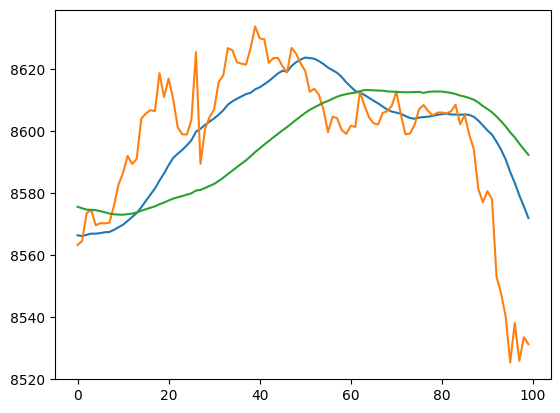

In [10]:
plt.plot(np.array(combined_df['MA_20'][:100]))
plt.plot(np.array(combined_df['Close'][:100]))
plt.plot(np.array(combined_df['MA_50'][:100]))


In [11]:
# If 'DateTime' is currently the DataFrame index, this makes it a column again:
combined_df.reset_index(drop=False, inplace=True)

# Now 'DateTime' is once again a column you can reference directly.
split_date = pd.to_datetime('2025-04-30 9:15:00')
train_df = combined_df[combined_df['DateTime'] < split_date].reset_index(drop=True)
test_df = combined_df[combined_df['DateTime'] >= split_date].reset_index(drop=True)

test_df.head(75)

,DateTime,Open,High,Low,Close,Volume,MA_20,MA_50,RSI_14,Close_Lag_1,Close_Lag_2,Close_Lag_3,CCI_20,BB_MA,BB_Upper,BB_Lower,Returns,Volatility_20
0,2025-04-30 09:15:00,24342.05,24342.05,24268.80,24317.60,0,24345.6050,24344.415,29.085140,24325.45,24333.10,24339.65,-192.805187,24345.6050,24374.629343,24316.580657,-0.000323,0.004167
1,2025-04-30 09:20:00,24320.35,24332.45,24297.75,24308.05,0,24343.0950,24343.591,29.585799,24317.60,24325.45,24333.10,-148.696904,24343.0950,24375.945344,24310.244656,-0.000393,0.004250
2,2025-04-30 09:25:00,24306.90,24325.15,24279.90,24324.05,0,24341.1200,24343.119,40.883459,24308.05,24317.60,24325.45,-140.246771,24341.1200,24373.539071,24308.700929,0.000658,0.004925
3,2025-04-30 09:30:00,24322.25,24352.50,24314.85,24338.05,0,24339.7625,24342.951,45.658747,24324.05,24308.05,24317.60,-21.505888,24339.7625,24370.145855,24309.379145,0.000576,0.005432
4,2025-04-30 09:35:00,24338.40,24365.65,24319.55,24364.65,0,24339.6975,24343.156,53.059701,24338.05,24324.05,24308.05,56.483651,24339.6975,24369.849648,24309.545352,0.001093,0.006794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2025-04-30 15:05:00,24370.35,24385.80,24370.35,24379.75,0,24347.5725,24343.656,66.333167,24370.30,24367.30,24376.70,190.750152,24347.5725,24377.013117,24318.131883,0.000388,0.005791
71,2025-04-30 15:10:00,24379.35,24381.00,24348.45,24348.85,0,24348.0950,24343.592,51.736247,24379.75,24370.30,24367.30,63.182574,24348.0950,24377.219413,24318.970587,-0.001267,0.007514
72,2025-04-30 15:15:00,24349.80,24353.15,24322.15,24324.00,0,24346.9625,24343.413,45.117387,24348.85,24379.75,24370.30,-87.119303,24346.9625,24378.020778,24315.904222,-0.001021,0.008265
73,2025-04-30 15:20:00,24323.75,24325.10,24289.95,24292.05,0,24344.0900,24342.655,36.240091,24324.00,24348.85,24379.75,-219.771489,24344.0900,24383.629049,24304.550951,-0.001314,0.009375


In [12]:
train_df.tail()

,DateTime,Open,High,Low,Close,Volume,MA_20,MA_50,RSI_14,Close_Lag_1,Close_Lag_2,Close_Lag_3,CCI_20,BB_MA,BB_Upper,BB_Lower,Returns,Volatility_20
180727,2025-04-29 15:05:00,24331.55,24336.50,24324.90,24332.70,0,24353.7900,24347.026,31.631919,24331.40,24340.20,24346.85,-194.269109,24353.7900,24375.659458,24331.920542,0.000053,0.004011
180728,2025-04-29 15:10:00,24332.60,24335.60,24324.45,24326.45,0,24351.7725,24346.517,23.687943,24332.70,24331.40,24340.20,-179.746218,24351.7725,24375.915090,24327.629910,-0.000257,0.004046
180729,2025-04-29 15:15:00,24326.20,24341.45,24310.60,24339.65,0,24350.4475,24345.968,34.430225,24326.45,24332.70,24331.40,-142.958342,24350.4475,24374.172846,24326.722154,0.000543,0.004615
180730,2025-04-29 15:20:00,24338.85,24348.50,24325.85,24333.10,0,24349.4075,24345.509,31.303358,24339.65,24326.45,24332.70,-94.180144,24349.4075,24374.290896,24324.524104,-0.000269,0.004383
180731,2025-04-29 15:25:00,24331.55,24340.85,24317.60,24325.45,0,24347.5075,24345.042,30.153509,24333.10,24339.65,24326.45,-124.991172,24347.5075,24373.647572,24321.367428,-0.000314,0.004165


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# -----------------------------
# (A) Configuration
# -----------------------------
candles_per_day = 75       # one trading day = 75 five‑min candles
input_days      = 2        # how many past days to use
input_seq_len   = candles_per_day * input_days  # 150
target_window   = candles_per_day               # 75

target_cols     = ['High', 'Low']
excluded_cols   = ['Returns', 'Volume']         # explicitly exclude Volume
all_cols        = list(train_df.columns)

# Select input features excluding target and excluded columns
input_features = [c for c in all_cols if c not in target_cols + excluded_cols]

print("Using these input features (Volume excluded):")
print(input_features)

# -----------------------------
# (B) Scale Inputs
# -----------------------------
feature_scalers = {}
scaled_inputs = pd.DataFrame(index=train_df.index)

for feat in input_features:
    sc = MinMaxScaler() #standardscalar
    scaled_inputs[feat] = sc.fit_transform(train_df[[feat]])
    feature_scalers[feat] = sc

# -----------------------------
# (C) Build Sequences + Targets
# -----------------------------
def create_sequences_and_targets(df_scaled, df_raw, input_features, input_len, tgt_window):
    X, y = [], []
    N = len(df_scaled) - input_len - tgt_window + 1
    for i in range(N):
        seq_x = df_scaled[input_features].iloc[i : i + input_len].values
        future = df_raw.iloc[i + input_len : i + input_len + tgt_window]
        high = future['High'].max()
        low  = future['Low'].min()
        X.append(seq_x)
        y.append([high, low])
    return np.array(X), np.array(y)

X, y_raw = create_sequences_and_targets(
    scaled_inputs, train_df, input_features, input_seq_len, target_window
)

print("X shape:", X.shape, "| y_raw shape:", y_raw.shape)

# -----------------------------
# (D) Scale Targets
# -----------------------------
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(y_raw)

# -----------------------------
# (E) Build & Train LSTM
# -----------------------------
model = Sequential([
    LSTM(64, input_shape=(input_seq_len, len(input_features))),
    Dense(len(target_cols))    # output: [High, Low]
])

model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(X, y, epochs=5, batch_size=256, verbose=1)

# -----------------------------
# (F) Predict Next Day’s High & Low
# -----------------------------
last_seq = scaled_inputs[input_features].iloc[-input_seq_len:].values
last_seq = np.expand_dims(last_seq, axis=0)   # shape: (1, 150, num_features)

pred_scaled = model.predict(last_seq)[0]
predicted  = target_scaler.inverse_transform(pred_scaled.reshape(1, -1))[0]

print("Forecast for next trading day:")
print(f"  High = {predicted[0]:.4f}")
print(f"  Low  = {predicted[1]:.4f}")

Using these input features (Volume excluded):
['DateTime', 'Open', 'Close', 'MA_20', 'MA_50', 'RSI_14', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'CCI_20', 'BB_MA', 'BB_Upper', 'BB_Lower', 'Volatility_20']
X shape: (180508, 150, 14) | y_raw shape: (180508, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 20,354
Trainable params: 20,354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
706/706 [==============================] - 8s 9ms/step - loss: 0.0015
Epoch 2/5
706/706 [==============================] - 6s 9ms/step - loss: 3.2940e-05
Epoch 3/5
706/706 [==

In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# -----------------------------
# (A) Configuration
# -----------------------------
candles_per_day = 75       # one trading day = 75 five‑min candles
input_days      = 2        # how many past days to use
input_seq_len   = candles_per_day * input_days  # 150
target_window   = candles_per_day               # 75

target_cols     = ['High', 'Low']
excluded_cols   = ['Returns', 'Volume']         # explicitly exclude Volume
all_cols        = list(train_df.columns)

# Select input features excluding target and excluded columns
input_features = [c for c in all_cols if c not in target_cols + excluded_cols]

print("Using these input features (Volume excluded):")
print(input_features)

# -----------------------------
# (B) Scale Inputs
# -----------------------------
feature_scalers = {}
scaled_inputs = pd.DataFrame(index=train_df.index)

for feat in input_features:
    sc = MinMaxScaler()
    scaled_inputs[feat] = sc.fit_transform(train_df[[feat]])
    feature_scalers[feat] = sc

# -----------------------------
# (C) Build Sequences + Targets
# -----------------------------
def create_sequences_and_targets(df_scaled, df_raw, input_features, input_len, tgt_window):
    X, y = [], []
    N = len(df_scaled) - input_len - tgt_window + 1
    for i in range(N):
        seq_x = df_scaled[input_features].iloc[i : i + input_len].values
        future = df_raw.iloc[i + input_len : i + input_len + tgt_window]
        high = future['High'].max()
        low  = future['Low'].min()
        X.append(seq_x)
        y.append([high, low])
    return np.array(X), np.array(y)

X, y_raw = create_sequences_and_targets(
    scaled_inputs, train_df, input_features, input_seq_len, target_window
)

print("X shape:", X.shape, "| y_raw shape:", y_raw.shape)

# -----------------------------
# (D) Scale Targets
# -----------------------------
target_scaler = MinMaxScaler()
y = target_scaler.fit_transform(y_raw)

# -----------------------------
# (E) Build & Train LSTM
# -----------------------------
model = Sequential([
    LSTM(64, input_shape=(input_seq_len, len(input_features))),
    Dense(len(target_cols))    # output: [High, Low]
])

model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(X, y, epochs=5, batch_size=256, verbose=1)

# -----------------------------
# (F) Predict Next Day’s High & Low
# -----------------------------
last_seq = scaled_inputs[input_features].iloc[-input_seq_len:].values
last_seq = np.expand_dims(last_seq, axis=0)   # shape: (1, 150, num_features)

pred_scaled = model.predict(last_seq)[0]
predicted  = target_scaler.inverse_transform(pred_scaled.reshape(1, -1))[0]

print("Forecast for next trading day:")
print(f"  High = {predicted[0]:.4f}")
print(f"  Low  = {predicted[1]:.4f}")


Using these input features (Volume excluded):
['DateTime', 'Open', 'Close', 'MA_20', 'MA_50', 'RSI_14', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'CCI_20', 'BB_MA', 'BB_Upper', 'BB_Lower', 'Volatility_20']
X shape: (180508, 150, 14) | y_raw shape: (180508, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 20,354
Trainable params: 20,354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
706/706 [==============================] - 7s 8ms/step - loss: 1.4639e-04
Epoch 2/5
706/706 [==============================] - 6s 8ms/step - loss: 2.9963e-05
Epoch 3/5
706/706